In [25]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm
from itertools import pairwise
import colormaps

from jetutils.definitions import DATADIR, DUNCANS_REGIONS_NAMES, YEARS, FIGURES, get_region, to_expr, compute
from jetutils.data import standardize, DataHandler, open_da
from jetutils.jet_finding import find_all_jets, average_jet_categories, jet_position_as_da, JetFindingExperiment
from jetutils.plots import Clusterplot, COLORS, COLORS_EXT
from jetutils.anyspell import make_daily, mask_from_spells_pl, subset_around_onset
from jetutils.frechet import fdfd_matrix, earth_haversine_numba
from jetutils.derived_quantities import compute_emf_2d_conv

%load_ext IPython.extensions.autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

The IPython.extensions.autoreload extension is already loaded. To reload it, use:
  %reload_ext IPython.extensions.autoreload


In [26]:
all_times = (
    pl.datetime_range(
        start=pl.datetime(1959, 1, 1),
        end=pl.datetime(2023, 1, 1),
        closed="left",
        interval="6h",
        eager=True,
        time_unit="ms",
    )
    .rename("time")
    .to_frame()
)
summer_filter = (
    all_times
    .filter(pl.col("time").dt.month().is_in([6, 7, 8, 9]))
    .filter(pl.col("time").dt.ordinal_day() > 166)
)
summer = summer_filter["time"]
summer_daily = summer.filter(summer.dt.hour() == 0)
big_summer = all_times.filter(pl.col("time").dt.month().is_in([6, 7, 8, 9]))
big_summer_daily = big_summer.filter(big_summer["time"].dt.hour() == 0)

dh = DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/8")
exp = JetFindingExperiment(dh)
ds = exp.ds
all_jets_one_df = exp.find_jets(force=False, base_s_thresh=0.55, hole_size=6)
all_jets_one_df = exp.categorize_jets(None, ["s", "theta"], force=False, n_init=10, init_params="k-means++", mode="week").cast({"time": pl.Datetime("ms")})
props_uncat = exp.props_as_df(False).cast({"time": pl.Datetime("ms")})

props_as_df = average_jet_categories(props_uncat, polar_cutoff=0.5)

props_summer = summer_filter.join(props_as_df, on="time")
phat_filter = (pl.col("is_polar") < 0.5) | ((pl.col("is_polar") > 0.5) & (pl.col("int") > 1.3e8))

phat_jets = all_jets_one_df.filter((pl.col("is_polar").mean().over(["time", "jet ID"]) < 0.5) | ((pl.col("is_polar").mean().over(["time", "jet ID"]) > 0.5) & (pl.col("int").mode().first().over(["time", "jet ID"]) > 1.3e8)))
phat_jets_catd = phat_jets.with_columns(**{"jet ID": (pl.col("is_polar").mean().over(["time", "jet ID"]) > 0.5).cast(pl.UInt32())})
phat_props = props_uncat.filter(phat_filter)
phat_props_catd = average_jet_categories(phat_props, polar_cutoff=0.5)

phat_props_catd = phat_props_catd.join(phat_props_catd.rolling("time", period="2d", group_by="jet").agg(**{f"{col}_var": pl.col(col).var() for col in ["mean_lon", "mean_lat", "mean_s", "s_star"]}), on=["time", "jet"])

phat_props_with_anoms = pl.read_parquet(exp.path.joinpath("phat_props_with_anoms.parquet"))

In [ ]:
ds = exp.ds
da_emf = xr.open_dataarray("/storage/workspaces/giub_meteo_impacts/ci01/ERA5/plev/uv/6H/results/EMFconv250.nc")
da_emf = da_emf.sel(time=np.isin(da_emf.time.dt.month, [6 ,7, 8, 9]), lon=slice(-80, 40), lat=slice(15, 80))
da_emf = compute(da_emf, progress_flag=True)
args1 = ["all", [6, 7, 8, 9], *(-10, 40, 10, 70)]
args2 = ["dayofyear", {"dayofyear": ("win", 15)}]
da_T_anom = DataHandler.from_specs(
    "ERA5",
    "surf",
    "t2m",
    "6H",
    *args1,
    "all",
    *args2,
).da
da_T_anom = compute(da_T_anom, progress_flag=True)
da_tp_anom = DataHandler.from_specs(
    "ERA5",
    "surf",
    "tp",
    "6H",
    *args1,
    "all",
    *args2,
).da
da_tp_anom = compute(da_tp_anom, progress_flag=True)

[########################################] | 100% Completed | 12m 9ss
[########################################] | 100% Completed | 11m 26s


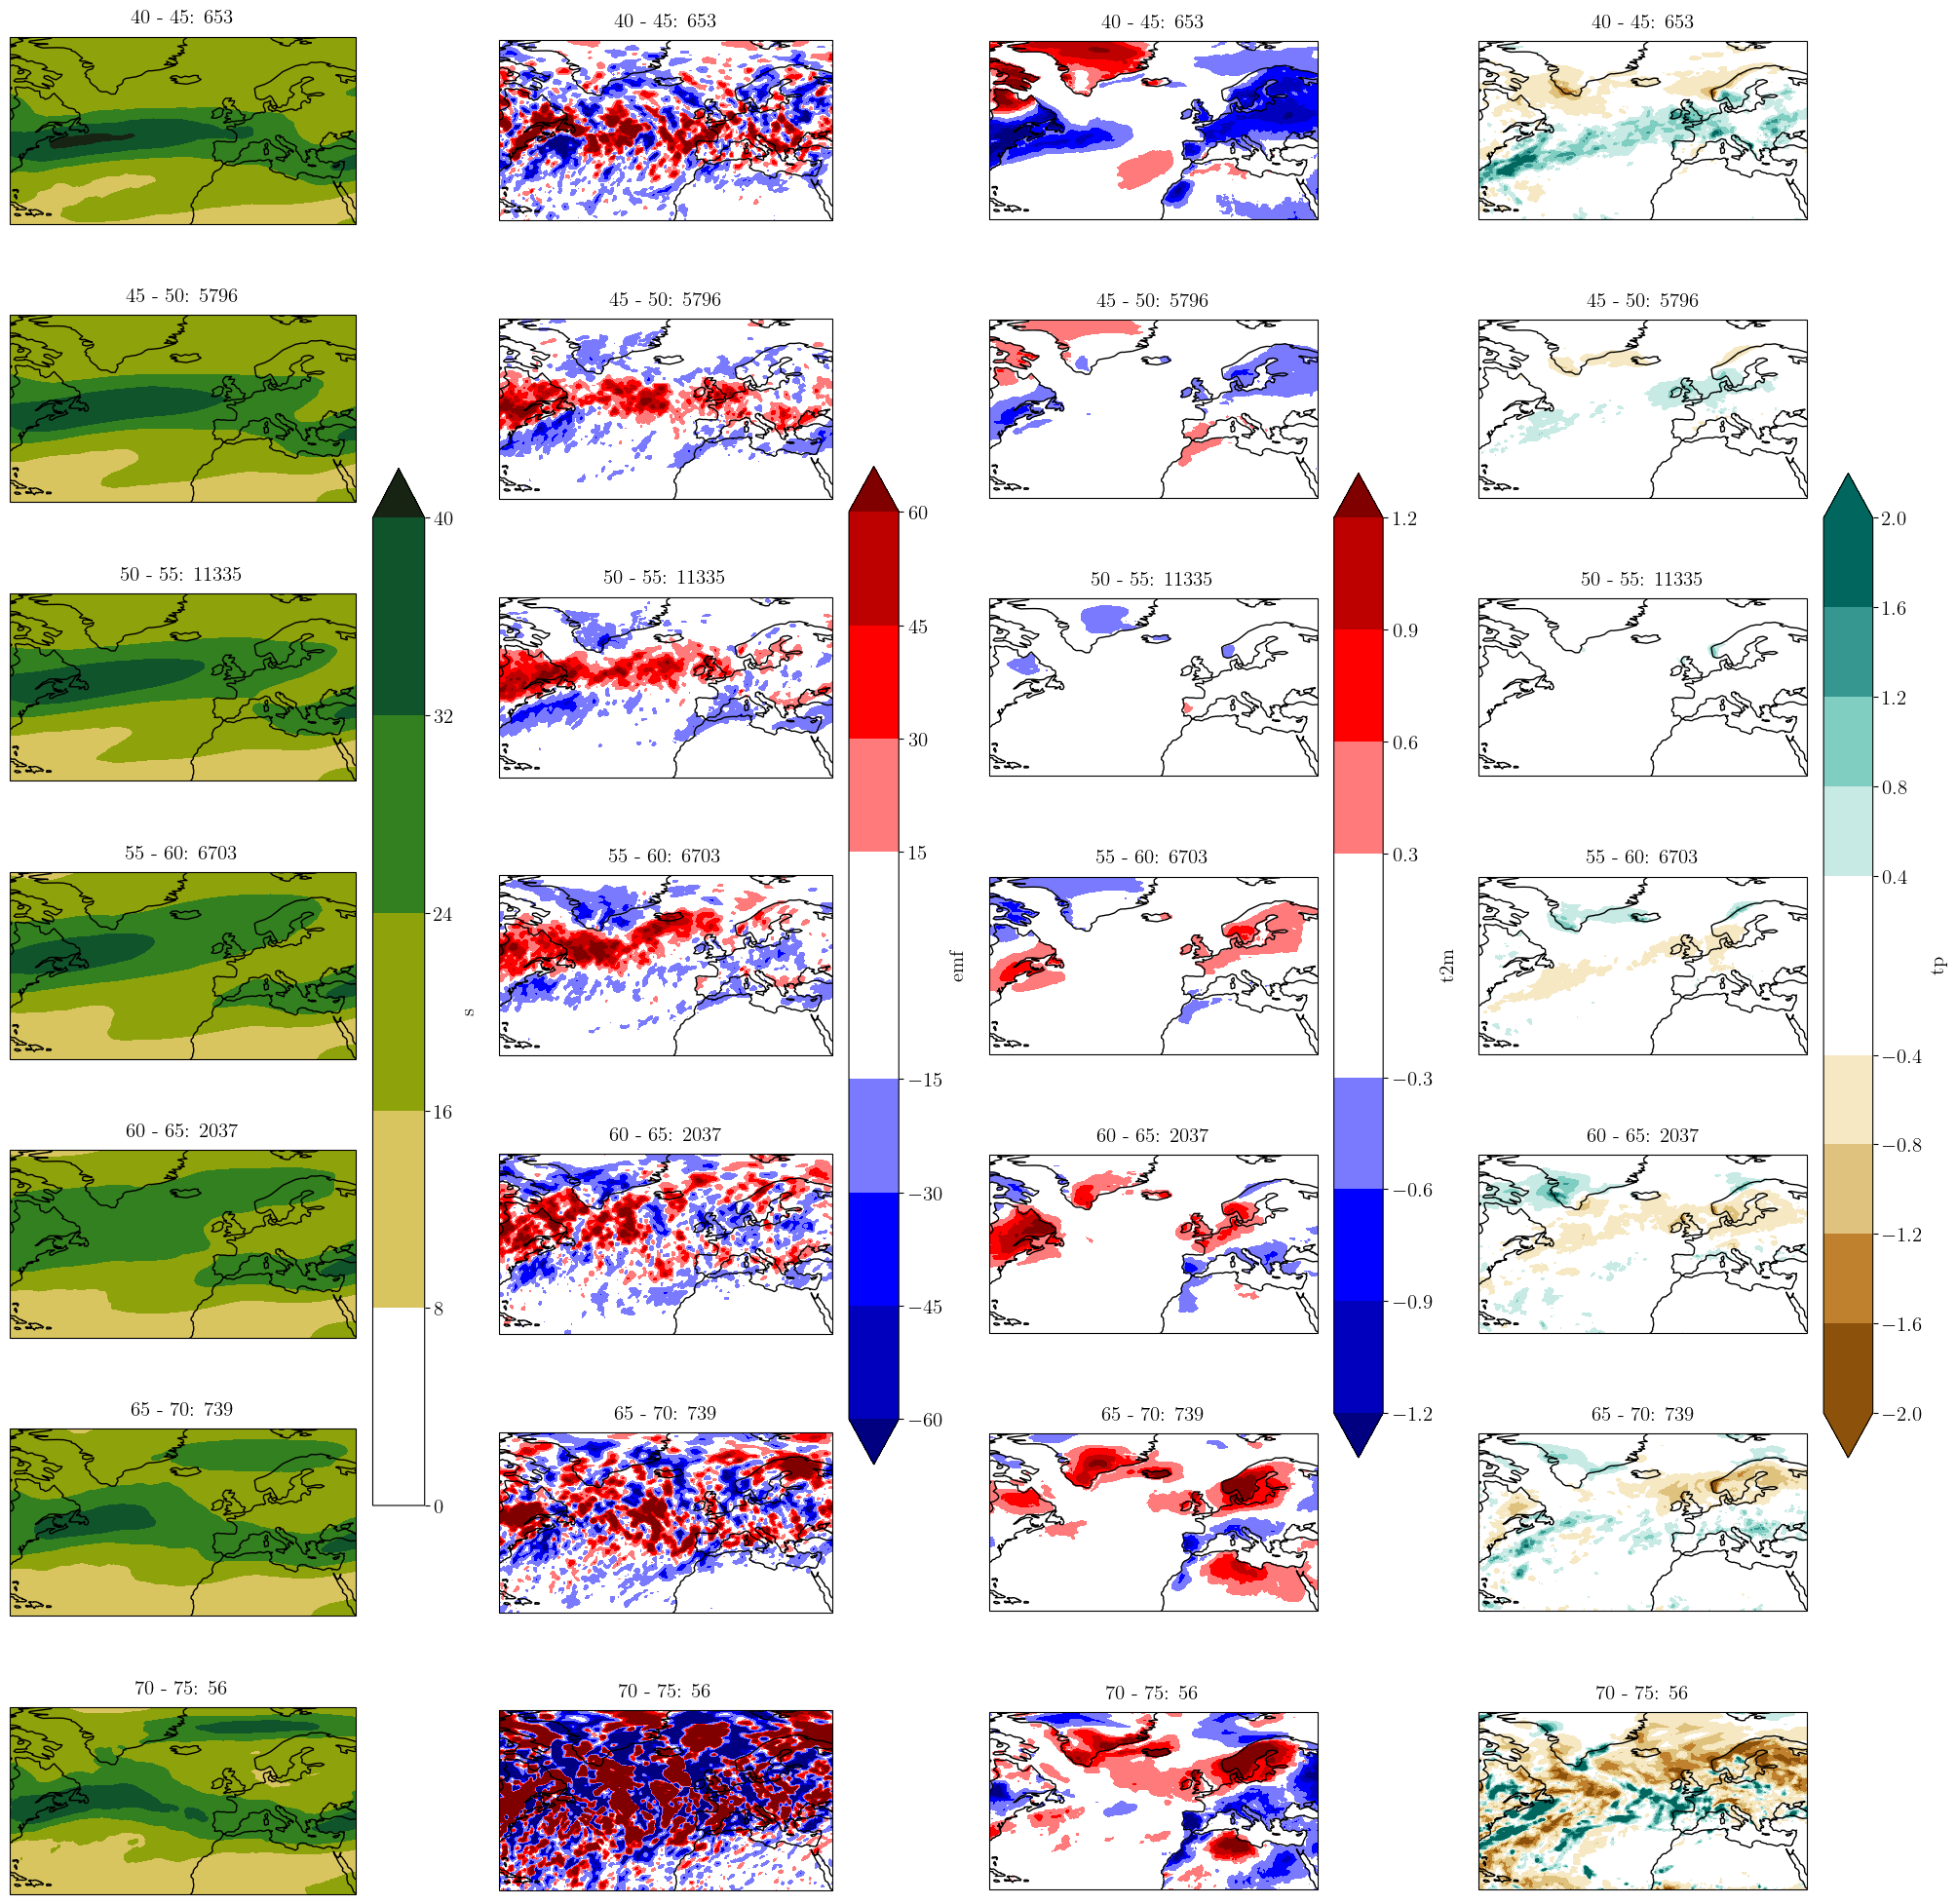

In [47]:
# s, emfconv, t, tp
# increasing edj lats, another one increasing overlap, then increasing stj speed
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
plot_kwargs = {
    "s": (ds["s"], colormaps.speed, 6, [0, 40]),
    "emf": (da_emf * 1e6, colormaps.BlWhRe, 7, [-50, 50]),
    "t2m": (da_T_anom, colormaps.BlWhRe, 7, [-1, 1]),
    "tp": (da_tp_anom * 1000, colormaps.brbg, 12, [-2, 2]),
}
figure = plt.figure(figsize=(20, 20), constrained_layout=True)
subfigures = figure.subfigures(1, 4)
jet = pl.col("jet") == "EDJ"
filters = [(l1, l2) for l1, l2 in pairwise(list(range(40, 80, 5)))]
titles = [f"{l1} - {l2}" for l1, l2 in filters]
filters = [(pl.col("mean_lat") >= l1) & (pl.col("mean_lat") <= l2) for l1, l2 in filters]
huh = phat_props_with_anoms.filter(pl.col("time").dt.month().is_in([6, 7, 8, 9]), jet)
times = [huh.filter(filter_)["time"] for filter_ in filters]
titles = [f"{title}: {len(time)}" for title, time in zip(titles, times)]
to_plot = {}
for varname, subfig in zip(plot_kwargs, subfigures):
    to_plot[varname] = []
    da = plot_kwargs[varname][0]
    clu = Clusterplot(len(filters), 1, get_region(da), fig=subfig)
    for time in times:
        to_plot[varname].append(da.sel(time=time).mean("time"))
    cmap, levels, (min_, max_) = plot_kwargs[varname][1:]
    levels = MaxNLocator(levels).tick_values(min_, max_)
    clu.add_contourf(to_plot[varname], cmap=cmap, levels=levels.tolist(), transparify=1, cbar_label=varname, titles=titles)

## regionalised

In [ ]:
from tqdm import trange
from jetutils.anyspell import regionalize
for month in trange(1, 13):
    month_str = str(month).zfill(2)
    clusters_da = np.abs(xr.open_dataarray(Path(DATADIR, "ERA5/heatwaves_duncan/cluster_df.nc")).load())
    clusters_da = clusters_da.interp(lat=np.arange(32, 72, 0.5), method="nearest")
    args1 = ["all", [month], *get_region(clusters_da)]
    ofile = exp.path.joinpath(f"region_T_6H_month{month_str}.parquet")
    if not ofile.is_file():
        da_T = open_da(
            "ERA5",
            "surf",
            "t2m",
            "6H",
            *args1,
        )
        da_T = compute(da_T, progress_flag=True)
        region_T_ts = regionalize(da_T, clusters_da, ["time"])
        region_T_ts.write_parquet(ofile)
        del da_T

    ofile = exp.path.joinpath(f"region_tp_6H_month{month_str}.parquet")
    if not ofile.is_file():
        da_tp = open_da(
            "ERA5",
            "surf",
            "tp",
            "6H",
            *args1
        )
        da_tp = compute(da_tp, progress_flag=True)
        region_tp_ts = regionalize(da_tp, clusters_da, ["time"])
        region_tp_ts.write_parquet(ofile)
        del da_tp
        
oui = []
for file in exp.path.glob("region_tp_6H_month*"):
    df = pl.read_parquet(file)
    oui.append(df)
pl.concat(oui).sort("time", "region").write_parquet("region_tp_6H.parquet")

oui = []
for file in exp.path.glob("region_T_6H_month*"):
    df = pl.read_parquet(file)
    oui.append(df)
pl.concat(oui).sort("time", "region").write_parquet("region_T_6H.parquet")